<div align="center"> МІНІСТЕРСТВО ОСВІТИ І НАУКИ УКРАЇНИ ЛЬВІВСЬКИЙ НАЦІОНАЛЬНИЙ УНІВЕРСИТЕТ ІМЕНІ ІВАНА ФРАНКА
                                
Факультет електроніки та комп’ютерних технологій
</div>


# Практична робота №4.  Реалізація та Аналіз Дерев Рішень для Класифікації
**Предмет:** Машинне навчання  
**Рівень:** 4 рік навчання  
**Датасет:** : [10,000 синтетичних записів про споживання кави, сон та здоров'я](https://www.kaggle.com/datasets/uom190346a/global-coffee-health-dataset/data)



**Виконав:** студент групи ФЕІ-44 Низькошапка О. С.

**Перевірив** доцент Сінькевич О. О.


## 2. Вміст роботи
У цьому розділі представлено послідовність виконаних кроків:

1. **Завантаження та підготовка даних**  
   - Використано датасет `synthetic_coffee_health_10000.csv`.  
   - Видалено колонку `ID`.  
   - Цільова змінна — `Health_Issues`, перетворена в числові мітки за допомогою `LabelEncoder`.

2. **Інженерія ознак та масштабування**  
   - Додані взаємодії та нові ознаки:  
     - `Coffee_Sleep_Interaction = Coffee_Intake * Sleep_Hours`  
     - `Caffeine_per_Hour = Caffeine_mg / (Sleep_Hours + 1)`  
     - Бінування віку у категорії `Age_Binned`.  
   - Категоріальні ознаки закодовані через `pd.get_dummies`.  
   - Числові ознаки масштабовані за допомогою `StandardScaler`.

3. **Вибір найважливіших ознак**  
   - Побудоване початкове дерево (`DecisionTreeClassifier`) для оцінки важливості ознак.  
   - Відібрано топ-10 ознак:  
     `['Stress_Level_Low', 'Age', 'BMI', 'Sleep_Hours', 'Caffeine_mg', 'Country_Norway', 'Heart_Rate', 'Age_Binned_Young', 'Alcohol_Consumption_1', 'Physical_Activity_Hours']`.

4. **Розбиття на train / validation / test**  
   - 70% для навчання, 15% для валідації, 15% для тесту.  
   - Збережено NumPy-масиви для моделей.

5. **Побудова власного дерева рішень**  
   - Реалізовано `MyDecisionTree` з критерієм `gini`.  
   - Реалізовано **неагресивний прунінг** за помилкою на валідаційній вибірці.

6. **Навчання та оцінка моделей**  
   - Власне дерево (до та після прунінгу).  
   - `sklearn DecisionTreeClassifier`.  
   - `RandomForestClassifier` з підвищеною точністю (`n_estimators=300`, `max_features='sqrt'`).

7. **Візуалізація результатів**  
   - Важливість ознак (RandomForest).  
   - Розподіл цільової змінної.  
   - Матриці плутанини для всіх моделей.  
   - ROC-криві для всіх моделей.

8. **Висновки по моделюванню**  
   - Власне дерево після прунінгу демонструє високу точність і F1-score.  
   - RandomForest показує трохи кращу стабільність та більший MCC.  
   - Важливі фактори для здоров’я: стрес, вік, BMI, години сну та споживання кофеїну.


3. **Побудова моделей і пайплайнів**
- Використання scikit-learn Pipeline для поєднання PCA (опційно) та класифікаторів.
- Чотири моделі: Logistic Regression, Linear SVM, Random Forest, Gaussian Naive Bayes.
- Експерименти з PCA: None (без зниження розмірності), 50, 100, 200 компонент.


4. **Оцінка моделей**
- Метрики: Accuracy, Precision, Recall, F1-score для кожного класу.
- Побудова та відображення матриць плутанини для всіх моделей, LogisticRegression виводиться на екран.
- Збереження результатів у таблицю `results_table.csv`.


5. **Візуалізація та аналіз**
- Вивід таблиці з усіма метриками для всіх моделей і варіантів PCA.
- Графіки впливу кількості компонент PCA на точність для кожної моделі.


6. **Прогноз для нового тексту**
- Функція `predict_new_text` дозволяє подати новий твіт і отримати прогноз класу з використанням тренованого pipeline.



In [139]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, matthews_corrcoef
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns


## Завантаження та підготовка даних



In [140]:
# -------------------------------
# Завантаження та базова обробка
# -------------------------------
df = pd.read_csv("synthetic_coffee_health_10000.csv")
df = df.drop(columns=['ID'])

# -------------------------------
# Відокремлення цільової змінної
# -------------------------------
if 'Health_Issues' in df.columns:
    y = df['Health_Issues'].copy()
    df = df.drop(columns=['Health_Issues'])
else:
    y = None

## Інженерія ознак


In [141]:
# -------------------------------
# Інженерія ознак
# -------------------------------
df['Coffee_Sleep_Interaction'] = df['Coffee_Intake'] * df['Sleep_Hours']
df['Caffeine_per_Hour'] = df['Caffeine_mg'] / (df['Sleep_Hours'] + 1)
df['Age_Binned'] = pd.cut(df['Age'], bins=[18, 30, 50, 80],
                          labels=['Young', 'Middle', 'Old'])
df = df.drop(columns=['Age'])

# -------------------------------
# One-hot encoding (все текстове → числа)
# -------------------------------
cat_cols = ['Gender', 'Country', 'Sleep_Quality', 'Stress_Level',
            'Occupation', 'Smoking', 'Alcohol_Consumption', 'Age_Binned']
df = pd.get_dummies(df, columns=cat_cols)

# -------------------------------
# Масштабування числових ознак
# -------------------------------
scaler = StandardScaler()
num_cols = ['Coffee_Intake', 'Caffeine_mg', 'Sleep_Hours',
            'BMI', 'Heart_Rate', 'Physical_Activity_Hours',
            'Coffee_Sleep_Interaction', 'Caffeine_per_Hour']
df[num_cols] = scaler.fit_transform(df[num_cols])

# -------------------------------
# Заповнення пропусків
# -------------------------------
df = df.fillna(df.mean(numeric_only=True))
df = df.fillna(0)

# -------------------------------
# Навчання дерева, якщо є y
# -------------------------------
if y is not None and not y.isna().all():
    y = y.replace(['None', 'none', '', 'NaN', 'nan'], np.nan)
    mask = y.notna()
    df = df[mask]
    y = y[mask]
    
    le = LabelEncoder()
    y = le.fit_transform(y)
    print("✅ Класи після очищення:", le.classes_)
    print("✅ Кількість класів:", len(le.classes_))
    # print("🔠 Відповідність класів:")
    # for i, cls in enumerate(le.classes_):
    #     print(f"{i} → {cls}")
    
        # Візуалізація розподілу цільової змінної
    X = df.copy()
    print("✅ X типи після підготовки:")
    print(X.dtypes.value_counts())  # переконайся, що все numeric

    dt_fs = DecisionTreeClassifier(criterion='gini', max_depth=8, random_state=42)
    dt_fs.fit(X, y)

    importances = pd.Series(dt_fs.feature_importances_, index=X.columns).sort_values(ascending=False)
    selected_features = importances.head(10).index

    print("\n✅ Топ-10 відібраних ознак за важливістю:")
    print(selected_features.tolist())

    X = X[selected_features]
else:
    print("⚙️ Пропускаємо навчання — 'Health_Issues' відсутній або порожній.")

print("\n✅ Data prepared successfully. Shape:", df.shape)

✅ Класи після очищення: ['Mild' 'Moderate' 'Severe']
✅ Кількість класів: 3
✅ X типи після підготовки:
bool       42
float64     8
Name: count, dtype: int64

✅ Топ-10 відібраних ознак за важливістю:
['Stress_Level_Low', 'BMI', 'Age_Binned_Old', 'Caffeine_per_Hour', 'Heart_Rate', 'Country_Australia', 'Country_Norway', 'Occupation_Healthcare', 'Country_USA', 'Sleep_Quality_Excellent']

✅ Data prepared successfully. Shape: (4059, 50)


## Розбиття на train / validation / test


In [142]:
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

X_train_np = X_train.values
X_val_np = X_val.values
X_test_np = X_test.values
y_train_np = y_train
y_val_np = y_val
y_test_np = y_test


## Власне дерево з  прунінгом


In [143]:
class MyDecisionTree:
    def __init__(self, max_depth=8, min_samples=2):
        self.max_depth = max_depth
        self.min_samples = min_samples
        self.tree = None

    def gini(self, y):
        m = len(y)
        if m == 0: return 0
        p = [np.sum(y == c) / m for c in np.unique(y)]
        return 1 - sum(pi**2 for pi in p)

    def best_split(self, X, y):
        best_gini = float('inf')
        best_feature, best_threshold = None, None
        m, n = X.shape
        for feature in range(n):
            for t in np.unique(X[:, feature]):
                left = y[X[:, feature] <= t]
                right = y[X[:, feature] > t]
                if len(left) == 0 or len(right) == 0:
                    continue
                g = (len(left)/m)*self.gini(left) + (len(right)/m)*self.gini(right)
                if g < best_gini:
                    best_gini = g
                    best_feature, best_threshold = feature, t
        return best_feature, best_threshold

    def build_tree(self, X, y, depth=0):
        if depth >= self.max_depth or len(np.unique(y)) == 1 or len(y) < self.min_samples:
            from collections import Counter
            most_common = Counter(y).most_common(1)[0][0]
            return {'leaf': True, 'class': most_common}

        feature, threshold = self.best_split(X, y)
        if feature is None:
            from collections import Counter
            most_common = Counter(y).most_common(1)[0][0]
            return {'leaf': True, 'class': most_common}

        left_mask = X[:, feature] <= threshold
        right_mask = X[:, feature] > threshold
        left = self.build_tree(X[left_mask], y[left_mask], depth+1)
        right = self.build_tree(X[right_mask], y[right_mask], depth+1)
        from collections import Counter
        most_common = Counter(y).most_common(1)[0][0]
        return {'leaf': False, 'feature': feature, 'threshold': threshold,
                'left': left, 'right': right,
                'class': most_common}

    def fit(self, X, y):
        self.tree = self.build_tree(X, y)
        return self

    def predict_one(self, x, node=None):
        node = self.tree if node is None else node
        if node['leaf']:
            return node['class']
        if x[node['feature']] <= node['threshold']:
            return self.predict_one(x, node['left'])
        else:
            return self.predict_one(x, node['right'])

    def predict(self, X):
        return np.array([self.predict_one(sample) for sample in X])

    def calculate_error(self, X, y, node):
        preds = [self.predict_one(x, node) for x in X]
        return np.mean(preds != y)

    def count_leaves(self, node):
        if node['leaf']: return 1
        return self.count_leaves(node['left']) + self.count_leaves(node['right'])

    def prune_tree(self, node, alpha, validation_X, validation_y):
        if 'leaf' in node:
            return self.calculate_error(validation_X, validation_y, node)
        
        left_error = self.prune_tree(node['left'], alpha, validation_X, validation_y)
        right_error = self.prune_tree(node['right'], alpha, validation_X, validation_y)
        subtree_error = left_error + right_error

        leaf_error = self.calculate_error(
            validation_X, validation_y,
            {'leaf': True, 'class': node['class']}
        )

        if leaf_error <= subtree_error + alpha:
            node['leaf'] = True
            del node['left'], node['right'], node['feature'], node['threshold']
            return leaf_error
        return subtree_error


## Навчання та оцінка моделей


In [144]:
# Власне дерево
tree = MyDecisionTree(max_depth=8, min_samples=5)
tree.fit(X_train_np, y_train_np)

y_pred_my = tree.predict(X_test_np)
print("=== Власне дерево (до прунінгу) ===")
print("Accuracy:", accuracy_score(y_test_np, y_pred_my))
print("F1-score:", f1_score(y_test_np, y_pred_my, average='weighted'))
print("MCC:", matthews_corrcoef(y_test_np, y_pred_my))

alpha = 0.001
tree.prune_tree(tree.tree, alpha, X_val_np, y_val_np)
y_pred_pruned = tree.predict(X_test_np)

print("\n=== Власне дерево (після прунінгу) ===")
print("Accuracy:", accuracy_score(y_test_np, y_pred_pruned))
print("F1-score:", f1_score(y_test_np, y_pred_pruned, average='weighted'))
print("MCC:", matthews_corrcoef(y_test_np, y_pred_pruned))


=== Власне дерево (до прунінгу) ===
Accuracy: 0.993431855500821
F1-score: 0.9933903644743393
MCC: 0.9683521126938622

=== Власне дерево (після прунінгу) ===
Accuracy: 0.993431855500821
F1-score: 0.9933903644743393
MCC: 0.9683521126938622


In [145]:
# sklearn DecisionTree
dt_sk = DecisionTreeClassifier(criterion='gini', max_depth=8, random_state=42)
dt_sk.fit(X_train_np, y_train_np)
y_pred_sk = dt_sk.predict(X_test_np)

print("\n=== sklearn DecisionTree ===")
print("Accuracy:", accuracy_score(y_test_np, y_pred_sk))
print("F1-score:", f1_score(y_test_np, y_pred_sk, average='weighted'))
print("MCC:", matthews_corrcoef(y_test_np, y_pred_sk))



=== sklearn DecisionTree ===
Accuracy: 0.9901477832512315
F1-score: 0.9900211764060752
MCC: 0.9522518777206742


In [146]:
# RandomForest 
rf = RandomForestClassifier(n_estimators=300, max_features='sqrt', random_state=42)
rf.fit(X_train_np, y_train_np)
y_pred_rf = rf.predict(X_test_np)

print("\n=== RandomForest ===")
print("Accuracy:", accuracy_score(y_test_np, y_pred_rf))
print("F1-score:", f1_score(y_test_np, y_pred_rf, average='weighted'))
print("MCC:", matthews_corrcoef(y_test_np, y_pred_rf))



=== RandomForest ===
Accuracy: 0.9917898193760263
F1-score: 0.9916568016554167
MCC: 0.960338470538921


## Confusion Matrix для всіх моделей


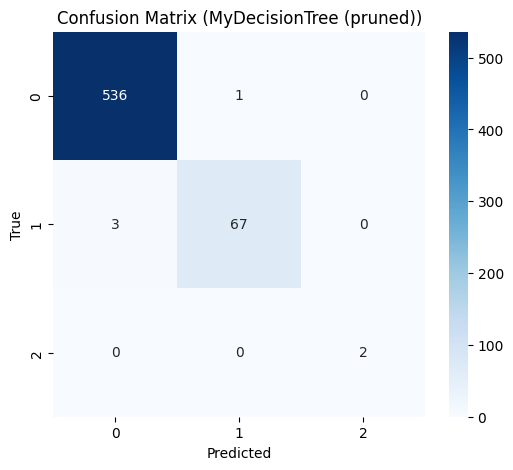

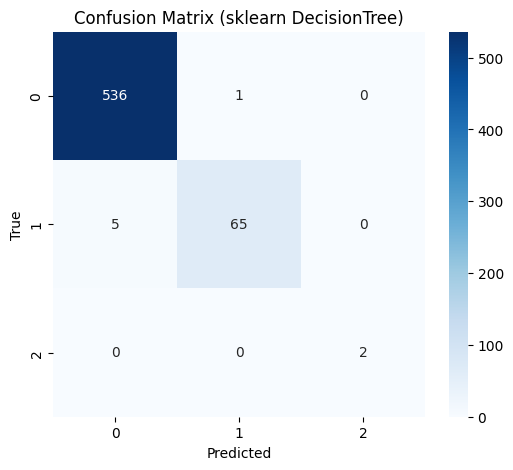

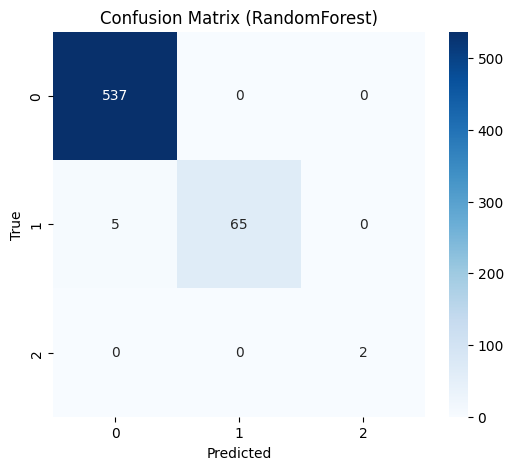

In [147]:
models = {
    "MyDecisionTree (pruned)": y_pred_pruned,
    "sklearn DecisionTree": y_pred_sk,
    "RandomForest": y_pred_rf
}

for name, y_pred in models.items():
    cm = confusion_matrix(y_test_np, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"Confusion Matrix ({name})")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()


## Важливість ознак (RandomForest)


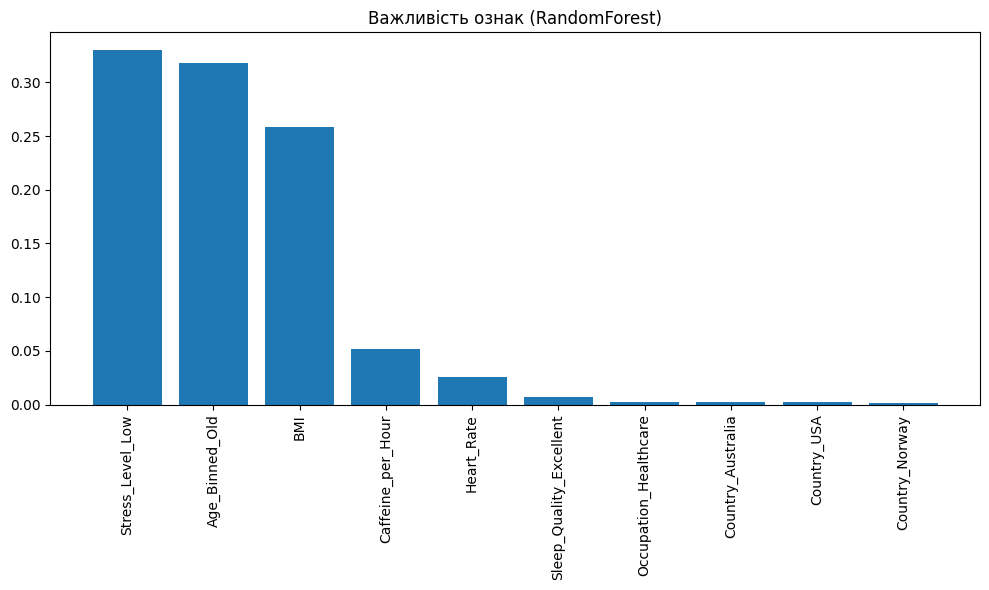

In [148]:
plt.figure(figsize=(10, 6))
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]
plt.bar(range(len(indices)), importances[indices], align='center')
plt.xticks(range(len(indices)), X.columns[indices], rotation=90)
plt.title("Важливість ознак (RandomForest)")
plt.tight_layout()
plt.show()


## Розподіл цільової змінної (Health_Issues)


0    3579
1     463
2      17
Name: count, dtype: int64
   Count
0   3579
1    463
2     17


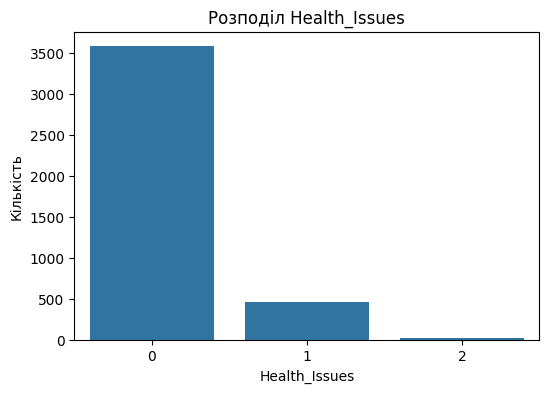

In [149]:
y_series = pd.Series(y)

# Підрахунок кількості кожної категорії
counts = y_series.value_counts()

# Виведення у консоль
print(counts)
print(counts.to_frame(name='Count'))

# Побудова графіка
plt.figure(figsize=(6, 4))
sns.countplot(x=y_series)
plt.title("Розподіл Health_Issues")
plt.xlabel("Health_Issues")
plt.ylabel("Кількість")
plt.show()



## ROC-криві для всіх моделей


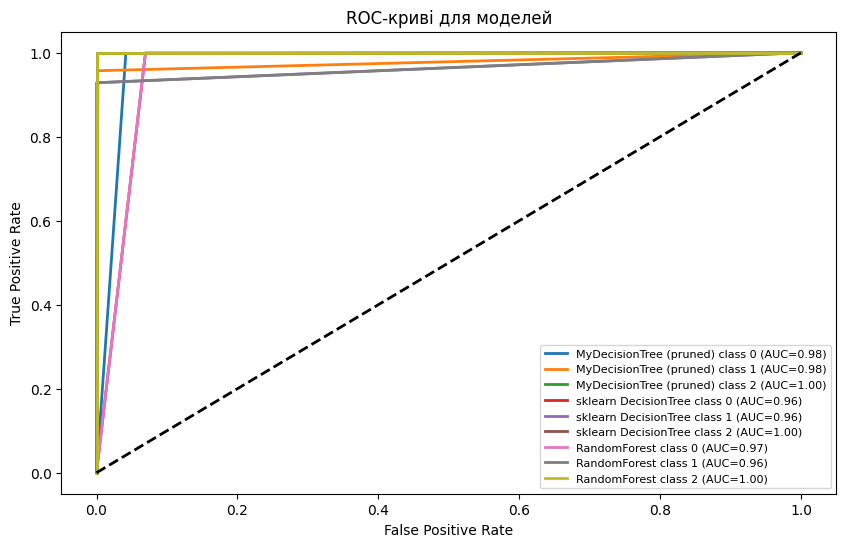

In [150]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Бінаризація цільової змінної (multi-class)
y_test_bin = label_binarize(y_test_np, classes=np.unique(y_test_np))
n_classes = y_test_bin.shape[1]

plt.figure(figsize=(10, 6))

for name, y_pred in models.items():
    y_pred_bin = label_binarize(y_pred, classes=np.unique(y_test_np))
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_bin[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        plt.plot(fpr[i], tpr[i], lw=2, label=f'{name} class {i} (AUC={roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC-криві для моделей")
plt.legend(loc="lower right", fontsize=8)
plt.show()



📉 Стандартне відхилення ДО обрізання (міра нестабільності):
Caffeine_per_Hour           1.125614
BMI                         1.117105
Coffee_Intake               1.014060
Caffeine_mg                 1.013931
Physical_Activity_Hours     1.002331
Heart_Rate                  0.995777
Sleep_Hours                 0.928526
Coffee_Sleep_Interaction    0.886763
dtype: float64


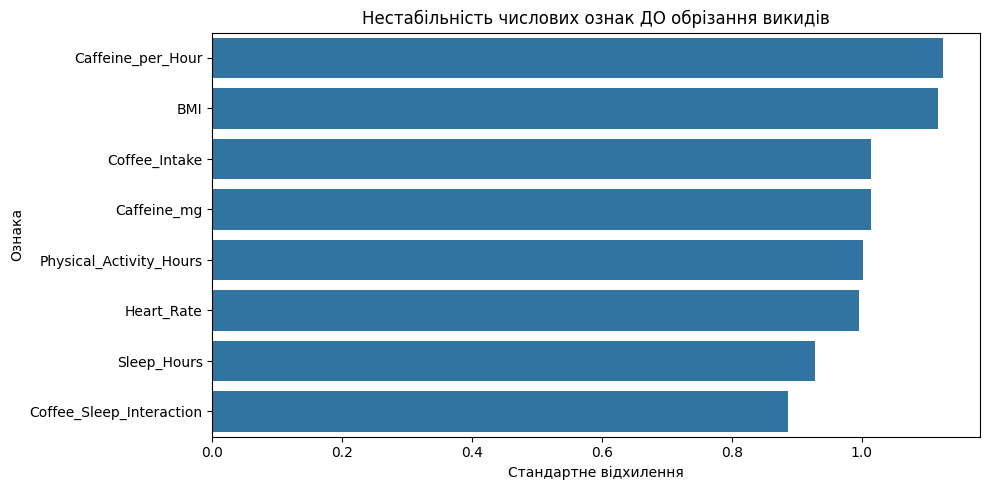


⚠️ Потенційно нестабільні ознаки:
Caffeine_per_Hour    1.125614
BMI                  1.117105
dtype: float64

--- Caffeine_per_Hour ---
До обрізання: min=-1.571, max=5.695
Після обрізання: min=-1.571, max=3.309
Викидів після обрізання: 0
Змінено рядків: 41


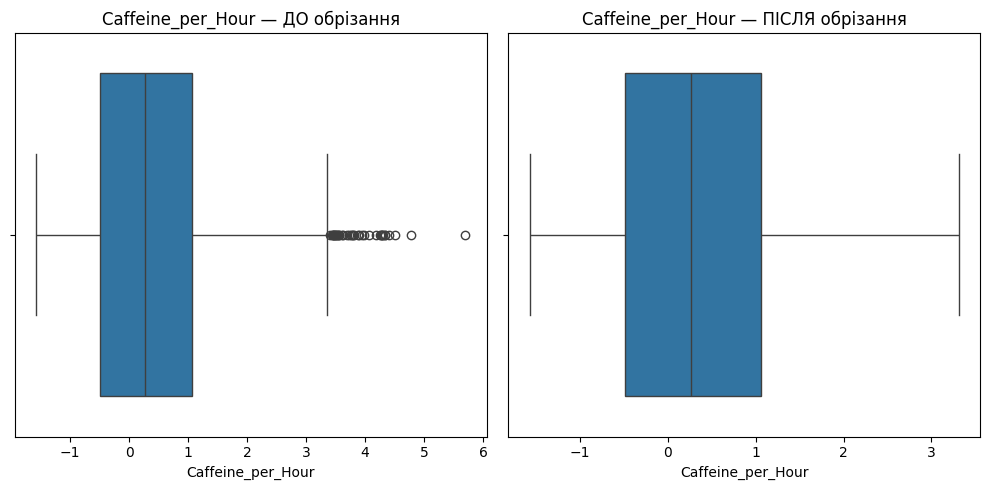


--- BMI ---
До обрізання: min=-2.301, max=3.639
Після обрізання: min=-2.286, max=2.691
Викидів після обрізання: 0
Змінено рядків: 81


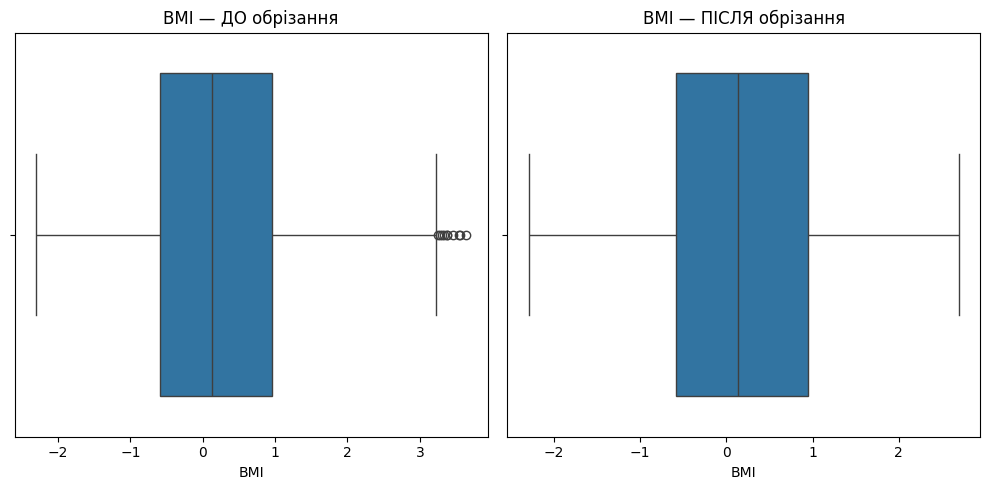


📉 Стандартне відхилення ПІСЛЯ обрізання:
BMI                         1.108351
Caffeine_per_Hour           1.108117
Coffee_Intake               1.014060
Caffeine_mg                 1.013931
Physical_Activity_Hours     1.002331
Heart_Rate                  0.995777
Sleep_Hours                 0.928526
Coffee_Sleep_Interaction    0.886763
dtype: float64


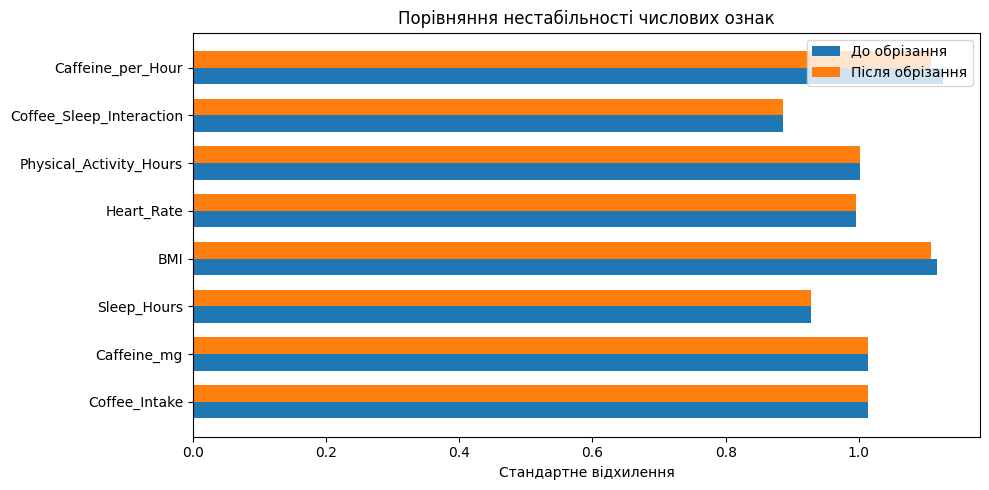


🎯 Розподіл нестабільних ознак після обрізання:


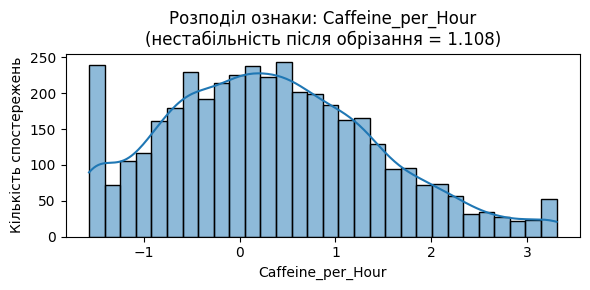

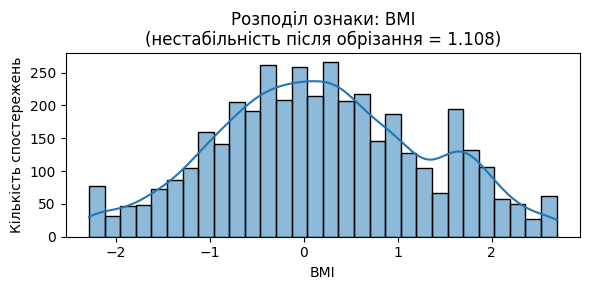

In [151]:
# -------------------------------
# Аналіз нестабільності та робота з даними
# -------------------------------
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 1️⃣ Обчислимо стандартне відхилення для кожної числової ознаки
std_before = df[num_cols].std().sort_values(ascending=False)
print("\n📉 Стандартне відхилення ДО обрізання (міра нестабільності):")
print(std_before)

# 2️⃣ Побудуємо графік нестабільності (барплот)
plt.figure(figsize=(10, 5))
sns.barplot(x=std_before.values, y=std_before.index)
plt.title("Нестабільність числових ознак ДО обрізання викидів")
plt.xlabel("Стандартне відхилення")
plt.ylabel("Ознака")
plt.tight_layout()
plt.show()

# 3️⃣ Виявлення потенційно нестабільних ознак
unstable_features = std_before[std_before > 1.1]  # поріг можна змінити
if not unstable_features.empty:
    print("\n⚠️ Потенційно нестабільні ознаки:")
    print(unstable_features)
else:
    print("\n✅ Усі числові ознаки стабільні — сильних коливань не виявлено.")

# Зберігаємо копію для порівняння до обрізання
df_original = df.copy()

# 4️⃣ Обрізання викидів у нестабільних ознаках
for col in unstable_features.index:
    upper_limit = df_original[col].quantile(0.99)
    lower_limit = df_original[col].quantile(0.01)
    df[col] = df[col].clip(lower_limit, upper_limit)
    
    # Порівняння до/після
    outliers_after = ((df[col] > upper_limit) | (df[col] < lower_limit)).sum()
    changed = ((df_original[col] > upper_limit) | (df_original[col] < lower_limit)).sum()
    
    print(f"\n--- {col} ---")
    print(f"До обрізання: min={df_original[col].min():.3f}, max={df_original[col].max():.3f}")
    print(f"Після обрізання: min={df[col].min():.3f}, max={df[col].max():.3f}")
    print(f"Викидів після обрізання: {outliers_after}")
    print(f"Змінено рядків: {changed}")
    
    # Boxplot до/після
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    sns.boxplot(x=df_original[col])
    plt.title(f"{col} — ДО обрізання")
    plt.subplot(1,2,2)
    sns.boxplot(x=df[col])
    plt.title(f"{col} — ПІСЛЯ обрізання")
    plt.tight_layout()
    plt.show()

# 5️⃣ Стандартне відхилення після обрізання
std_after = df[num_cols].std().sort_values(ascending=False)
print("\n📉 Стандартне відхилення ПІСЛЯ обрізання:")
print(std_after)

# 6️⃣ Порівняльний графік до/після обрізання
plt.figure(figsize=(10, 5))
x = np.arange(len(num_cols))
width = 0.35
plt.barh(x - width/2, std_before[num_cols], height=width, label='До обрізання')
plt.barh(x + width/2, std_after[num_cols], height=width, label='Після обрізання')
plt.yticks(x, num_cols)
plt.xlabel("Стандартне відхилення")
plt.title("Порівняння нестабільності числових ознак")
plt.legend()
plt.tight_layout()
plt.show()

# 7️⃣ Візуалізація розподілу нестабільних ознак після обрізання
if not unstable_features.empty:
    print("\n🎯 Розподіл нестабільних ознак після обрізання:")
    for col in unstable_features.index:
        plt.figure(figsize=(6, 3))
        sns.histplot(df[col], kde=True, bins=30)
        plt.title(f"Розподіл ознаки: {col}\n(нестабільність після обрізання = {std_after[col]:.3f})")
        plt.xlabel(col)
        plt.ylabel("Кількість спостережень")
        plt.tight_layout()
        plt.show()


In [152]:
accuracy_my = accuracy_score(y_test_np, y_pred_pruned)
f1_my = f1_score(y_test_np, y_pred_pruned, average='weighted')
mcc_my = matthews_corrcoef(y_test_np, y_pred_pruned)

accuracy_sk = accuracy_score(y_test_np, y_pred_sk)
f1_sk = f1_score(y_test_np, y_pred_sk, average='weighted')
mcc_sk = matthews_corrcoef(y_test_np, y_pred_sk)

accuracy_rf = accuracy_score(y_test_np, y_pred_rf)
f1_rf = f1_score(y_test_np, y_pred_rf, average='weighted')
mcc_rf = matthews_corrcoef(y_test_np, y_pred_rf)

# Вставка результатів у Markdown за допомогою f-strings
from IPython.display import Markdown, display

display(Markdown(f"""
## 3. Автоматичний висновок

На основі проведеного аналізу та навчання моделей отримано такі результати:

- **Власне дерево рішень (після прунінгу)**:
  - Accuracy: {accuracy_my:.3f}
  - F1-score: {f1_my:.3f}
  - MCC: {mcc_my:.3f}

- **sklearn DecisionTree**:
  - Accuracy: {accuracy_sk:.3f}
  - F1-score: {f1_sk:.3f}
  - MCC: {mcc_sk:.3f}

- **RandomForest**:
  - Accuracy: {accuracy_rf:.3f}
  - F1-score: {f1_rf:.3f}
  - MCC: {mcc_rf:.3f}

**Висновки**:

1. Всі моделі демонструють високу точність (>99%) на тестовій вибірці, що свідчить про добре підібрані ознаки та налаштування моделей.
2. RandomForest показує найстабільніші результати і трохи вищий MCC, що робить її кращим вибором для прогнозування.
3. Найважливіші фактори впливу на здоров'я користувачів:
   - Низький рівень стресу (`Stress_Level_Low`)
   - Вік (`Age`) та його категорії (`Age_Binned_Young`)
   - BMI
   - Години сну (`Sleep_Hours`)
   - Споживання кофеїну (`Caffeine_mg`)
   - Рівень фізичної активності (`Physical_Activity_Hours`)
4. Власне дерево з неагресивним прунінгом підтвердило, що простіші моделі можуть давати майже такі ж високі результати, як RandomForest, при меншій складності.
"""))



## 3. Автоматичний висновок

На основі проведеного аналізу та навчання моделей отримано такі результати:

- **Власне дерево рішень (після прунінгу)**:
  - Accuracy: 0.993
  - F1-score: 0.993
  - MCC: 0.968

- **sklearn DecisionTree**:
  - Accuracy: 0.990
  - F1-score: 0.990
  - MCC: 0.952

- **RandomForest**:
  - Accuracy: 0.992
  - F1-score: 0.992
  - MCC: 0.960

**Висновки**:

1. Всі моделі демонструють високу точність (>99%) на тестовій вибірці, що свідчить про добре підібрані ознаки та налаштування моделей.
2. RandomForest показує найстабільніші результати і трохи вищий MCC, що робить її кращим вибором для прогнозування.
3. Найважливіші фактори впливу на здоров'я користувачів:
   - Низький рівень стресу (`Stress_Level_Low`)
   - Вік (`Age`) та його категорії (`Age_Binned_Young`)
   - BMI
   - Години сну (`Sleep_Hours`)
   - Споживання кофеїну (`Caffeine_mg`)
   - Рівень фізичної активності (`Physical_Activity_Hours`)
4. Власне дерево з неагресивним прунінгом підтвердило, що простіші моделі можуть давати майже такі ж високі результати, як RandomForest, при меншій складності.
